Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [190]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
import pickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [191]:
model_folder = 'data/model/'
trajectory_folder = 'data/trajectory/'
optimal_trajectory_folder = 'data/optimal_trajectory/'

---
# 2 - Robot modelling

## Create joint variables and define their relations

In [192]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# define paralelogram coordinate relation
# q3 = -q2 + q4
# q5 = -q4 + q2

## Robot geometry definition in following order

| Joint number | previous link | successive links | $a$ | $\alpha$ | $d$ | $\theta$ | inertia | motor inertia |
|--------------|---------------|------------------|-----|----------|-----|----------|---------|---------------|

In [263]:
# robot_def = RobotDef([(0,   -1, [1],    0, 0, 0, 0),
#                       (1,   0,  [2, 4], 0, 0, -0.21537, q1),
#                       (2,   1,  [3],    0, -sympy.pi/2, 0, q2+sympy.pi/2),
#                       (3,   2,  [],    0.279, 0, 0, q3+sympy.pi/2),
#                       (4,   1,  [5],    0, -sympy.pi/2, 0, q4+sympy.pi),
#                       (5,   4,  [],     0.1, 0, 0, q5-sympy.pi/2)],
#                      dh_convention='mdh',
#                      friction_type=['Coulomb', 'viscous', 'offset'])

robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0,                  False, False),
                      (1,   0,  [2],    0,      0,              -0.21537,   q1,                 True,  False),
                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2,      True,  False),
                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2,  True,  False)],
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])

In [264]:
robot_def.dq_for_frame

In [265]:
robot_def.std_params

In [266]:
robot_def.bary_params

## Create kinematics chain

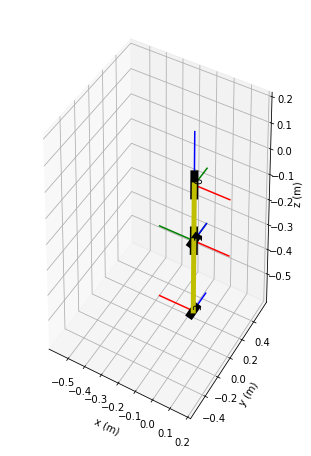

In [267]:
geom.draw_geom()

In [268]:
geom = Geometry(robot_def)


In [269]:
geom.T_0nc[1]

⎡                      l1x⋅cos(q₁)   l1y⋅sin(q₁)⎤
⎢cos(q₁)  -sin(q₁)  0  ─────────── - ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                      l1x⋅sin(q₁)   l1y⋅cos(q₁)⎥
⎢sin(q₁)  cos(q₁)   0  ─────────── + ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                            l1z                ⎥
⎢   0        0      1        ─── - 0.21537      ⎥
⎢                             m₁                ⎥
⎢                                               ⎥
⎣   0        0      0              1            ⎦

## Create dynamics

In [270]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating joint torques...
Adding frictions...
dq0_da0 = 0, tau_f = 0
dq0_da1 = 0, tau_f = 0
dq0_da2 = 0, tau_f = 0
dq1_da0 = 1, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
dq1_da1 = 0, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
dq1_da2 = 0, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
dq2_da0 = 0, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
dq2_da1 = 1, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
dq2_da2 = 0, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
dq3_da0 = 0, tau_f = Fc3*sign(dq3) + Fo3 + Fv3*dq3
dq3_da1 = 0, tau_f = Fc3*sign(dq3) + Fo3 + Fv3*dq3
dq3_da2 = 1, tau_f = Fc3*sign(dq3) + Fo3 + Fv3*dq3
Calculating gregressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 24
Creating H_b function...
Finished creating robot dynamics
CPU times: user 1min 17s, sys: 160 ms, total: 1min 17s
Wall time: 1min 16s


In [271]:
dyn._calc_base_param()

Calculating base parameter...
base parameter number: 24
Creating H_b function...


In [272]:
sympy.Matrix(dyn.base_param)

⎡             1.0⋅l3x              ⎤
⎢                                  ⎥
⎢             1.0⋅l3y              ⎥
⎢                                  ⎥
⎢             1.0⋅L3xy             ⎥
⎢                                  ⎥
⎢        1.0⋅l2x + 0.279⋅m₃        ⎥
⎢                                  ⎥
⎢             1.0⋅L3xz             ⎥
⎢                                  ⎥
⎢             1.0⋅l2y              ⎥
⎢                                  ⎥
⎢             1.0⋅L3yz             ⎥
⎢                                  ⎥
⎢             1.0⋅L2xy             ⎥
⎢                                  ⎥
⎢       -1.0⋅L3xx + 1.0⋅L3yy       ⎥
⎢                                  ⎥
⎢             1.0⋅L2yz             ⎥
⎢                                  ⎥
⎢             1.0⋅L3zz             ⎥
⎢                                  ⎥
⎢       1.0⋅L2xz - 0.279⋅l3z       ⎥
⎢                                  ⎥
⎢-1.0⋅L2xx + 1.0⋅L2yy + 0.077841⋅m₃⎥
⎢                                  ⎥
⎢             1.0⋅Fv₂              ⎥
⎢

---
# 3 - Excitation trajectory optimization

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [273]:
base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(dyn, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)])
traj_optimizer.optimize()

joint constraint number: 2
cartisian constraint number: 0
constraint number: 8
Condition number: 21.1577037242
x: [ 0.27543847 -0.03166844 -0.3329902   0.03218404 -0.028754   -0.69312081
  0.59355108 -0.17025495 -0.36545063  0.52605522 -0.83728735  0.66917501
  0.52843864  0.37122602  0.53349257  0.396837    0.8908343  -0.47710689
 -0.86978601  0.14274714  0.45182056  0.85425456  0.00877344 -0.15823852
  0.92431199  0.7798629   1.06414714  0.91426913 -0.64206391 -0.5064832
 -0.81719956  0.96118079  0.72082076  0.85148437 -0.56400551  0.84549444
  0.52626862 -0.74778078 -0.58309635]

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   11.1127
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name        Value        Optimum
	     f         21.1577             0

	Variables (c -

## Plot optimal excitation trajectory

('traj:', 0)
('traj:', 1)
('traj:', 2)


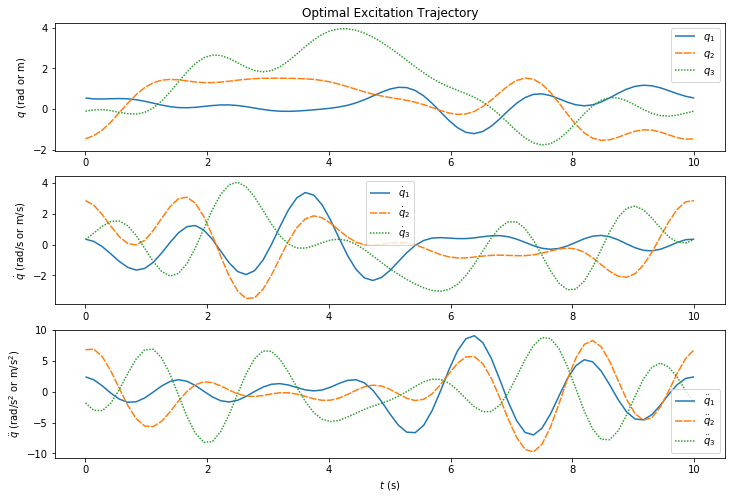

In [274]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

## Save trajectory for later use

In [275]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)


In [276]:
dof_order_bf_x_file_name = 'optimal_traj1.pkl'
dof_order_bf_x_dir = optimal_trajectory_folder + dof_order_bf_x_file_name

#if not os.path.exists(dof_order_bf_x_dir):
with open(dof_order_bf_x_dir, 'wr') as f:
    pickle.dump(dyn.H_b, f)

---
# Data processing

In [277]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [278]:
trajectory_data_file = trajectory_folder + 'test.csv'
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(trajectory_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [279]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


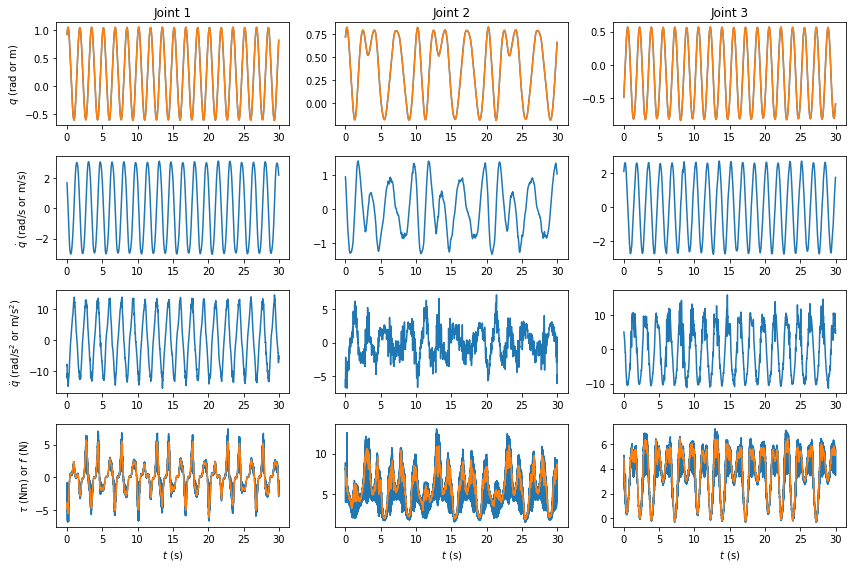

In [280]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [281]:
traj_optimizer.x_result

array([ 0.27543847, -0.03166844, -0.3329902 ,  0.03218404, -0.028754  ,
       -0.69312081,  0.59355108, -0.17025495, -0.36545063,  0.52605522,
       -0.83728735,  0.66917501,  0.52843864,  0.37122602,  0.53349257,
        0.396837  ,  0.8908343 , -0.47710689, -0.86978601,  0.14274714,
        0.45182056,  0.85425456,  0.00877344, -0.15823852,  0.92431199,
        0.7798629 ,  1.06414714,  0.91426913, -0.64206391, -0.5064832 ,
       -0.81719956,  0.96118079,  0.72082076,  0.85148437, -0.56400551,
        0.84549444,  0.52626862, -0.74778078, -0.58309635])

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [282]:
base_param_num = dyn.base_num
H_b_func = dyn.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [283]:
print(W_b.shape, tau_s.shape)

((17970, 24), (17970,))


In [284]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [285]:
sympy.Matrix.hstack(sympy.Matrix(dyn.base_param), sympy.Matrix(xb_ols))

⎡             1.0⋅l3x                  0.444294094117088  ⎤
⎢                                                         ⎥
⎢             1.0⋅l3y                 0.0744451512660674  ⎥
⎢                                                         ⎥
⎢             1.0⋅L3xy                -0.0204855925496505 ⎥
⎢                                                         ⎥
⎢        1.0⋅l2x + 0.279⋅m₃            0.844444821276342  ⎥
⎢                                                         ⎥
⎢             1.0⋅L3xz               -0.000341120353468826⎥
⎢                                                         ⎥
⎢             1.0⋅l2y                 0.0309348191578374  ⎥
⎢                                                         ⎥
⎢             1.0⋅L3yz                0.00147247321323989 ⎥
⎢                                                         ⎥
⎢             1.0⋅L2xy                0.00164920211520686 ⎥
⎢                                                         ⎥
⎢       -1.0⋅L3xx + 1.0⋅L3yy           0

## Compare measured torque and predicted torque

### Generate predicted torque

In [286]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]

### Evaluate regression

In [287]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0022703017412518825
standard deviation of xb using OLS:
[3.64499428e-04 2.31706662e-04 7.64830648e-05 8.03845900e-04
 9.37242263e-05 1.78212285e-03 1.85197569e-04 1.82110740e-04
 1.80157996e-04 2.60397695e-04 1.35617274e-04 1.97527572e-04
 4.67085477e-04 1.68171811e-03 7.37232175e-04 1.15913319e-03
 1.65905695e-04 4.86407231e-04 3.13981530e-03 6.15787727e-04
 1.71759174e-02 1.35500993e-03 1.40336021e-03 1.55554016e-03]
percentage of standard deviation of xb using OLS: 
[0.0008204  0.00311245 0.00373351 0.00095192 0.27475413 0.05760896
 0.12577313 0.11042354 0.00169923 0.40630079 0.00103644 0.55591482
 0.00177764 0.0588114  0.28425867 0.07443275 0.00338564 0.00268109
 0.04651468 0.09667674 0.17232203 0.15458806 0.08618206 0.15323904]


### Plot measured torque and predicted torque

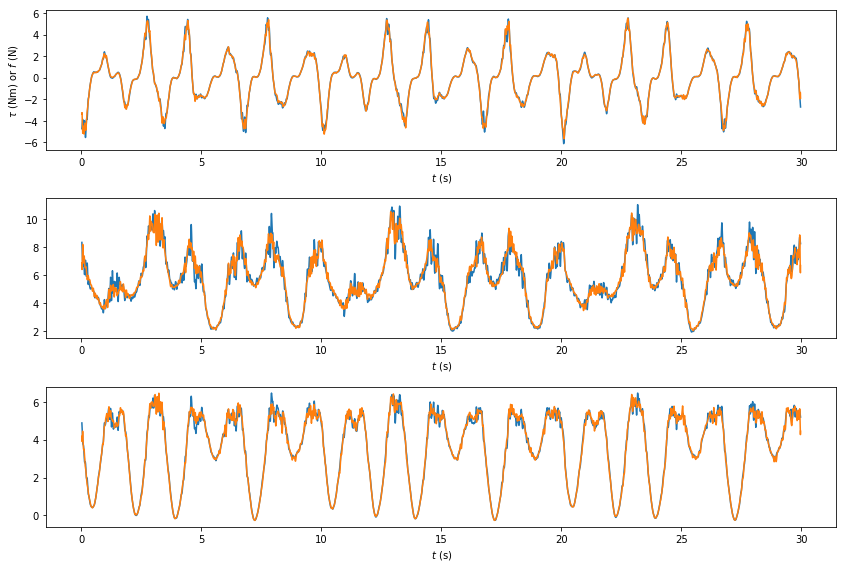

In [288]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

## Convex optimization

In [289]:
# #from identification import SDPOpt
# import cvxpy as cp

# # sdp_opt = SDPOpt(W_b, tau_s, None)
# # sdp_opt.solve()
# m, n = W_b.shape
# sdp_x = cp.Variable(n)
# sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
# sdp_constraints = []
# sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

# result = sdp_prob.solve(solver=cp.OSQP)

# print(sdp_x.value)

In [290]:
# xb_ols

### Generate regressor matrix for barycentric parameters

In [354]:
from identification import SDPOpt

bary_param_num = len(robot_def.bary_params)
H_func = dyn.H_func
W, tau_s = gen_regressor(bary_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [355]:
len(robot_def.std_params)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [377]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
# sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
#                   (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
#                   (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05),
#                   (0.5, 5, -0.1, 0.1, 0, 0.1, -0.1, 0.1),
#                   (0.1, 1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1),]
sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
                  (0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.05, 0.05),
                  (0.5, 10, 0, 0.3, 0, 0.1, -0.05, 0.05)]

sdp_constraints = [(0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 2, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01)]

In [ ]:
sdp_opt_std = SDPOpt(W, tau_s, robot_def, sdp_constraints)
sdp_opt_std.solve()

Regressor shape: (17970, 39)
Regressand shape: (17970,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...


In [ ]:
len(sdp_opt_std._constraints)

## Compare measured torque and predicted torque

### Generate predicted torque

In [374]:
tau_sdp_p = np.zeros(tau_f.shape)
tau_sdp_ps = W.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_sdp_p[:, i] = tau_sdp_ps[i::dof]

### Plot measured torque and predicted torque

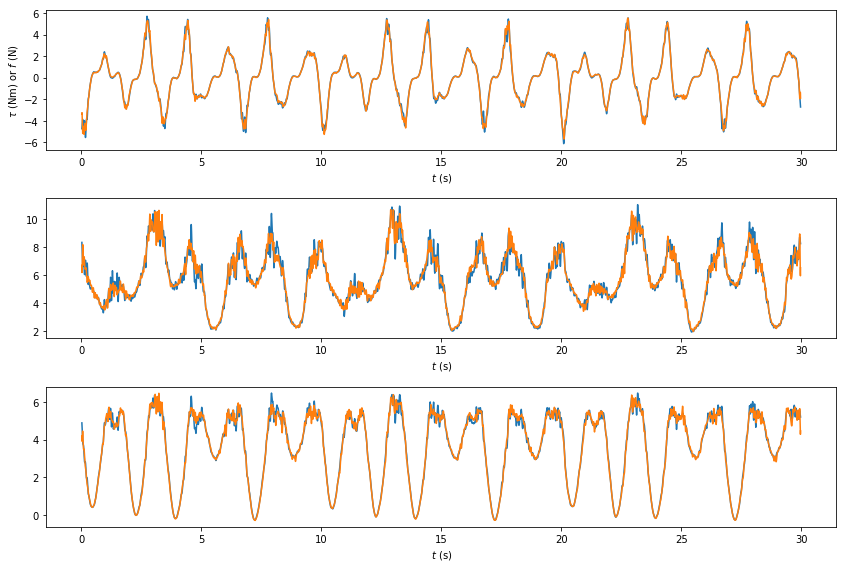

In [375]:
plot_meas_pred_tau(t_cut, tau_f, tau_sdp_p)

In [376]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.bary_params), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx   4.69679563602588e-6 ⎤
⎢                           ⎥
⎢L1xy           0.0         ⎥
⎢                           ⎥
⎢L1xz           0.0         ⎥
⎢                           ⎥
⎢L1yy   4.69679563602588e-6 ⎥
⎢                           ⎥
⎢L1yz           0.0         ⎥
⎢                           ⎥
⎢L1zz  0.000957935495921409 ⎥
⎢                           ⎥
⎢l1x            0.0         ⎥
⎢                           ⎥
⎢l1y            0.0         ⎥
⎢                           ⎥
⎢l1z            0.0         ⎥
⎢                           ⎥
⎢ m₁     1.59191375265465   ⎥
⎢                           ⎥
⎢Fc₁   0.000917512782449241 ⎥
⎢                           ⎥
⎢Fv₁    0.00639823473195536 ⎥
⎢                           ⎥
⎢Fo₁    0.00627855340908864 ⎥
⎢                           ⎥
⎢L2xx   0.0134713289136489  ⎥
⎢                           ⎥
⎢L2xy   0.00246947369244061 ⎥
⎢                           ⎥
⎢L2xz   0.0006345799834869  ⎥
⎢                           ⎥
⎢L2yy    0.151712288009352  ⎥
⎢         

In [347]:
from identification import barycentric2standard_params

In [348]:
sdp_opt_std.x_result

array([ 4.88379053e-06,  0.00000000e+00,  0.00000000e+00,  4.88379053e-06,
        0.00000000e+00,  9.05229732e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.67703725e+00, -9.84366931e-04,  5.93306052e-03,
        6.27378514e-03,  4.32257387e-02,  5.63393150e-04,  5.75879517e-04,
        1.65800991e-01,  3.10236264e-03,  4.97410477e-02,  3.39709860e-01,
        2.93133382e-02, -1.50690826e-02,  1.00001805e+01,  1.86565173e-02,
        6.84630466e-03, -5.33463666e-02,  4.53536915e-03, -2.08481849e-02,
       -6.38476214e-04,  1.12046457e-01,  1.27563181e-03,  1.31691687e-01,
        4.38862689e-01,  7.48291301e-02,  9.27128827e-04,  1.82190038e+00,
        2.12205966e-02,  5.89319146e-04,  1.11663882e-01])

In [349]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_def)

In [350]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.std_params), sympy.Matrix(x_std))

⎡I1xx   4.88379052810528e-6 ⎤
⎢                           ⎥
⎢I1xy            0          ⎥
⎢                           ⎥
⎢I1xz            0          ⎥
⎢                           ⎥
⎢I1yy   4.88379052810528e-6 ⎥
⎢                           ⎥
⎢I1yz            0          ⎥
⎢                           ⎥
⎢I1zz   9.05229732313068e-5 ⎥
⎢                           ⎥
⎢r1x            0.0         ⎥
⎢                           ⎥
⎢r1y            0.0         ⎥
⎢                           ⎥
⎢r1z            0.0         ⎥
⎢                           ⎥
⎢ m₁     3.67703725260028   ⎥
⎢                           ⎥
⎢Fc₁   -0.000984366931223852⎥
⎢                           ⎥
⎢Fv₁    0.00593306051763905 ⎥
⎢                           ⎥
⎢Fo₁    0.0062737851365104  ⎥
⎢                           ⎥
⎢I2xx   0.0431171057110954  ⎥
⎢                           ⎥
⎢I2xy   0.00155917818025668 ⎥
⎢                           ⎥
⎢I2xz   6.39771608606151e-5 ⎥
⎢                           ⎥
⎢I2yy    0.154238213165703  ⎥
⎢         